# Moleculenet

The `MoleculeNetDataset` class is intended for datasets that consist of a table of smiles and corresponding targets and convert them into a tensors representation for graph networks. The class provides properties and methods for making graph features from smiles.
The typical input is a `csv` or `excel` file with smiles and corresponding graph labels.

The graph structure matches the molecular graph, i.e. the chemical structure. And features for atoms and bonds are generated with `RDkit` chemical informatics software.

The atomic coordinates
are generated by a conformer guess. Since this require some computation time, it is only done once and the
molecular coordinate or mol-blocks stored in a single SDF file with the base-name of the csv file.

For demonstration, we make an artifical table of smiles and some values and store them to file.

In [1]:
import os
os.makedirs("ExampleMol", exist_ok=True)
csv_data = "".join([
    "smiles,Values1,Values2\n",  # Need header!
    "CCC, 1, 0.1\n",
    "CCCO, 2, 0.3\nCCCN, 3, 0.2\n",
    "CCCC=O, 4, 0.4\n"
    "NOCF, 4, 1.4\n"
])
with open("ExampleMol/data.csv", "w") as f:
    f.write(csv_data)

The file structure is:


```bash
├── ExampleMol
    ├── data.csv
    └── data.sdf  # After prepare_data
```

In [2]:
from kgcnn.data.moleculenet import MoleculeNetDataset, OneHotEncoder

ERROR:root:Module 'mol' is deprecated and will be removed in future versions. Please move to 'kgcnn.molecule'.
ERROR:kgcnn.molecule.convert:Can not import `RDKit` package for conversion.


## 1. Initialization

To load the dataset from memeory the ``MoleculeNetDataset`` class requires the information of the directory the data is in and the name of the csv-file. Also recommended is to provide a name of the dataset.

In [3]:
dts = MoleculeNetDataset(file_name="data.csv", 
                         data_directory="ExampleMol/", 
                         dataset_name="ExampleMol")

## 2. Data Preparation

Precompute the molecular structure and possibly also coordinates and cache the information to file as SDF mol table format in the same folder as provided in the class initialization. The structure generation can be run in parallel but the SDF file generated may be large and must still fit in memory.

In [4]:
dts.prepare_data(
    overwrite=True, 
    smiles_column_name="smiles", 
    add_hydrogen=True,
    make_conformers=True,
    optimize_conformer=True,
    num_workers=None  # Default is #cpus
)

INFO:kgcnn.data.ExampleMol:Generating molecules and store ExampleMol/data.sdf to disk...
INFO:kgcnn.data.ExampleMol: ... converted molecules 5 from 5


<MoleculeNetDataset []>

## 3. Read Data

After ``prepare_data()`` is called, the cached mol-file can be read directly from the data-directory.
The reading step can also define the labels or targets to assigning property `graph_labels` from the column of the csv table. By default a simple graph is generated without attributes.

In [5]:
dts.read_in_memory(
    label_column_name=["Values1", "Values2"], 
    add_hydrogen=False,  # We remove H's 
    has_conformers=True  # We keep strucutre
)
print("Number of graphs:", len(dts))

INFO:kgcnn.data.ExampleMol:Read molecules from mol-file.
INFO:kgcnn.data.ExampleMol: ... process molecules 0 from 5
INFO:kgcnn.molecule.encoder:OneHotEncoder Symbol found ['C', 'O', 'N', 'F']
INFO:kgcnn.molecule.encoder:OneHotEncoder Hybridization found [rdkit.Chem.rdchem.HybridizationType.SP3, rdkit.Chem.rdchem.HybridizationType.SP2]
INFO:kgcnn.molecule.encoder:OneHotEncoder TotalDegree found [4, 2, 3, 1]
INFO:kgcnn.molecule.encoder:OneHotEncoder TotalNumHs found [3, 2, 1, 0]
INFO:kgcnn.molecule.encoder:OneHotEncoder CIPCode found [None]
INFO:kgcnn.molecule.encoder:OneHotEncoder ChiralityPossible found [None]
INFO:kgcnn.molecule.encoder:OneHotEncoder BondType found [rdkit.Chem.rdchem.BondType.SINGLE, rdkit.Chem.rdchem.BondType.DOUBLE]
INFO:kgcnn.molecule.encoder:OneHotEncoder Stereo found [rdkit.Chem.rdchem.BondStereo.STEREONONE]


Number of graphs: 5


## 4. Setting Attributes

For molecular graphs nodes, edges or atoms and bonds should have attributes that are for `MoleculeNetDataset` generated from `RDkit` that includes chirality, stereo information (etc). Note that if a smile can not be processed by `RDkit` the graph will not have attributes.

This can be achieved by setting a list of identifiers of predefined attributes or supply custom functions.
Additionally an encoder can be provided to cast or transform the `RDkit` data formats into a list or value that eventually be cast into numpy `dtype="float"` array. Also one-hot-encoding or mapping on to distributions can be handled by encoders. Attributes 

In [6]:
# Class to make attributes used by MoleculeNetDataset
import rdkit.Chem as Chem
from kgcnn.molecule.graph_rdkit import MolecularGraphRDKit
mol = MolecularGraphRDKit()
# Identifiers:
print("Atoms:", list(mol.atom_fun_dict.keys()))
print("Bonds:", list(mol.bond_fun_dict.keys()))
print("Molecule:", list(mol.mol_fun_dict.keys()))

Atoms: ['NumBonds', 'AtomicNum', 'AtomMapNum', 'Idx', 'Degree', 'TotalDegree', 'Symbol', 'NumExplicitHs', 'NumImplicitHs', 'TotalNumHs', 'IsAromatic', 'Isotope', 'TotalValence', 'Mass', 'MassScaled', 'IsInRing', 'Hybridization', 'NoImplicit', 'ChiralTag', 'FormalCharge', 'ExplicitValence', 'ImplicitValence', 'NumRadicalElectrons', 'HasOwningMol', 'PDBResidueInfo', 'MonomerInfo', 'Smarts', 'CIPCode', 'CIPRank', 'ChiralityPossible', 'MolFileRLabel', 'GasteigerCharge', 'GasteigerHCharge', 'AtomFeatures', 'DescribeQuery', 'Rvdw', 'RvdwScaled', 'Rcovalent', 'RcovalentScaled']
Bonds: ['BondType', 'IsAromatic', 'IsConjugated', 'IsInRing', 'Stereo', 'Idx', 'BeginAtom', 'BeginAtomIdx', 'BondDir', 'BondTypeAsDouble', 'EndAtom', 'EndAtomIdx', 'Smarts', 'DescribeQuery']
Molecule: ['C', 'N', 'O', 'H', 'S', 'F', 'Cl', 'NumAtoms', 'AtomsIsInRing', 'AtomsIsAromatic', 'NumBonds', 'BondsIsConjugated', 'BondsIsAromatic', 'NumRotatableBonds', 'ExactMolWt', 'FpDensityMorgan3', 'FractionCSP3', 'MolLogP', 'M

Custom functions must take a `RDkit` Mol, Atom or Bond instance as input for node edge or graph respectively.

In [7]:
# Or make custom function
def mol_feature(m):
    return m.GetNumAtoms()

Or using a callback directly for a new attribute, which takes the csv table and molecule list as argument.

In [8]:
def graph_size_callback(mg, ds):
    return mg.mol.GetNumAtoms()

Or using custom transform

In [9]:
def custum_trafo(mg):
    return mg.compute_partial_charges()

In [10]:
dts.set_attributes(
    # Nodes
    nodes=["Symbol", "TotalNumHs", "GasteigerCharge"], 
    encoder_nodes={
        "Symbol": OneHotEncoder(["C", "N", "O"], dtype="str", add_unknown=False)
    },
    # Edges
    edges=["BondType", "Stereo"], 
    encoder_edges = {
        "BondType": int
    },
    # Graph-level
    graph=["ExactMolWt", mol_feature],
    additional_callbacks= {"size": graph_size_callback},
    custom_transform=custum_trafo
)

INFO:kgcnn.data.ExampleMol:Read molecules from mol-file.
INFO:kgcnn.data.ExampleMol: ... process molecules 0 from 5
INFO:kgcnn.molecule.encoder:OneHotEncoder Symbol found ['C', 'O', 'N', 'F']


<MoleculeNetDataset [{'node_symbol': array(['C', 'C', 'C'], dtype='<U1'), 'node_number': array([6, 6, 6]), 'edge_indices': array([[0, 1],
       [1, 0],
       [1, 2],
       [2, 1]], dtype=int64), 'edge_number': array([1, 1, 1, 1]), 'graph_size': array(3), 'node_coordinates': array([[ 1.0384e+00,  2.4100e-02,  9.4900e-02],
       [ 2.5575e+00,  1.5000e-03,  7.7600e-02],
       [ 3.0907e+00, -1.1286e+00, -7.8660e-01]]), 'graph_labels': array([1, 0.1], dtype=object), 'node_attributes': array([[ 1.        ,  0.        ,  0.        ,  3.        , -0.06564544],
       [ 1.        ,  0.        ,  0.        ,  2.        , -0.05903836],
       [ 1.        ,  0.        ,  0.        ,  3.        , -0.06564544]],
      dtype=float32), 'edge_attributes': array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32), 'graph_attributes': array([44.0626,  3.    ], dtype=float32), 'size': array(3)} ...]>

## 4. Checking graphs in dataset 

In [11]:
import networkx as nx

In [12]:
dts.get("node_number"), dts.get("node_symbol")

([array([6, 6, 6]),
  array([6, 6, 6, 8]),
  array([6, 6, 6, 7]),
  array([6, 6, 6, 6, 8]),
  array([7, 8, 6, 9])],
 [array(['C', 'C', 'C'], dtype='<U1'),
  array(['C', 'C', 'C', 'O'], dtype='<U1'),
  array(['C', 'C', 'C', 'N'], dtype='<U1'),
  array(['C', 'C', 'C', 'C', 'O'], dtype='<U1'),
  array(['N', 'O', 'C', 'F'], dtype='<U1')])

In [13]:
print(dts[3])

{'node_symbol': array(['C', 'C', 'C', 'C', 'O'], dtype='<U1'), 'node_number': array([6, 6, 6, 6, 8]), 'edge_indices': array([[0, 1],
       [1, 0],
       [1, 2],
       [2, 1],
       [2, 3],
       [3, 2],
       [3, 4],
       [4, 3]], dtype=int64), 'edge_number': array([1, 1, 1, 1, 1, 1, 2, 2]), 'graph_size': array(5), 'node_coordinates': array([[ 0.9479,  0.0108, -0.0847],
       [ 2.4679,  0.0108, -0.0847],
       [ 2.9746,  0.3912,  1.297 ],
       [ 4.4946,  0.3912,  1.297 ],
       [ 5.13  ,  0.6834,  2.3581]]), 'graph_labels': array([4, 0.4], dtype=object), 'node_attributes': array([[ 1.0000000e+00,  0.0000000e+00,  0.0000000e+00,  3.0000000e+00,
        -6.4970836e-02],
       [ 1.0000000e+00,  0.0000000e+00,  0.0000000e+00,  2.0000000e+00,
        -4.9520925e-02],
       [ 1.0000000e+00,  0.0000000e+00,  0.0000000e+00,  2.0000000e+00,
         2.7463208e-03],
       [ 1.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00,
         1.1947978e-01],
       [ 0.0000000e

In [14]:
G = nx.Graph()
G.add_nodes_from([(i, {"atom": x}) for i, x in enumerate(dts.get("node_symbol")[3])])
G.add_edges_from(dts.get("edge_indices")[3])

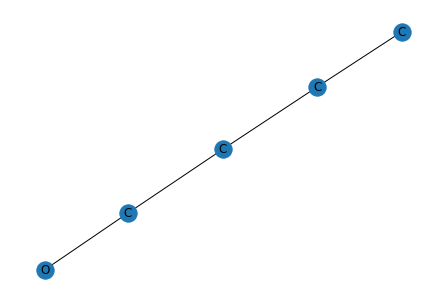

In [15]:
labels = nx.get_node_attributes(G, 'atom') 
nx.draw(G,labels=labels)

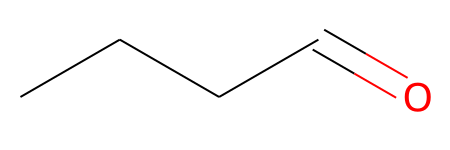

In [16]:
Chem.MolFromSmiles("CCCC=O")

Checking the output of ``set_attributes`` method

In [17]:
dts.get("node_attributes")

[array([[ 1.        ,  0.        ,  0.        ,  3.        , -0.06564544],
        [ 1.        ,  0.        ,  0.        ,  2.        , -0.05903836],
        [ 1.        ,  0.        ,  0.        ,  3.        , -0.06564544]],
       dtype=float32),
 array([[ 1.        ,  0.        ,  0.        ,  3.        , -0.06319688],
        [ 1.        ,  0.        ,  0.        ,  2.        , -0.03273489],
        [ 1.        ,  0.        ,  0.        ,  2.        ,  0.04278928],
        [ 0.        ,  0.        ,  1.        ,  1.        , -0.39638734]],
       dtype=float32),
 array([[ 1.        ,  0.        ,  0.        ,  3.        , -0.06417979],
        [ 1.        ,  0.        ,  0.        ,  2.        , -0.04375392],
        [ 1.        ,  0.        ,  0.        ,  2.        , -0.00799057],
        [ 0.        ,  1.        ,  0.        ,  2.        , -0.3304839 ]],
       dtype=float32),
 array([[ 1.0000000e+00,  0.0000000e+00,  0.0000000e+00,  3.0000000e+00,
         -6.4970836e-02],
    

In [18]:
dts.get("edge_attributes")

[array([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]], dtype=float32),
 array([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]], dtype=float32),
 array([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]], dtype=float32),
 array([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [2., 0.],
        [2., 0.]], dtype=float32),
 array([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]], dtype=float32)]

In [19]:
dts.get("graph_attributes")

[array([44.0626,  3.    ], dtype=float32),
 array([60.057514,  4.      ], dtype=float32),
 array([59.073498,  4.      ], dtype=float32),
 array([72.05752,  5.     ], dtype=float32),
 array([65.027695,  4.      ], dtype=float32)]

In [20]:
dts.get("graph_labels")

[array([1, 0.1], dtype=object),
 array([2, 0.3], dtype=object),
 array([3, 0.2], dtype=object),
 array([4, 0.4], dtype=object),
 array([4, 1.4], dtype=object)]

In [21]:
dts.save()

INFO:kgcnn.data.ExampleMol:Pickle dataset...


<MoleculeNetDataset [{'node_symbol': array(['C', 'C', 'C'], dtype='<U1'), 'node_number': array([6, 6, 6]), 'edge_indices': array([[0, 1],
       [1, 0],
       [1, 2],
       [2, 1]], dtype=int64), 'edge_number': array([1, 1, 1, 1]), 'graph_size': array(3), 'node_coordinates': array([[ 1.0384e+00,  2.4100e-02,  9.4900e-02],
       [ 2.5575e+00,  1.5000e-03,  7.7600e-02],
       [ 3.0907e+00, -1.1286e+00, -7.8660e-01]]), 'graph_labels': array([1, 0.1], dtype=object), 'node_attributes': array([[ 1.        ,  0.        ,  0.        ,  3.        , -0.06564544],
       [ 1.        ,  0.        ,  0.        ,  2.        , -0.05903836],
       [ 1.        ,  0.        ,  0.        ,  3.        , -0.06564544]],
      dtype=float32), 'edge_attributes': array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32), 'graph_attributes': array([44.0626,  3.    ], dtype=float32), 'size': array(3)} ...]>

In [22]:
dts.load()

INFO:kgcnn.data.ExampleMol:Load pickled dataset...


<MoleculeNetDataset [{'node_symbol': array(['C', 'C', 'C'], dtype='<U1'), 'node_number': array([6, 6, 6]), 'edge_indices': array([[0, 1],
       [1, 0],
       [1, 2],
       [2, 1]], dtype=int64), 'edge_number': array([1, 1, 1, 1]), 'graph_size': array(3), 'node_coordinates': array([[ 1.0384e+00,  2.4100e-02,  9.4900e-02],
       [ 2.5575e+00,  1.5000e-03,  7.7600e-02],
       [ 3.0907e+00, -1.1286e+00, -7.8660e-01]]), 'graph_labels': array([1, 0.1], dtype=object), 'node_attributes': array([[ 1.        ,  0.        ,  0.        ,  3.        , -0.06564544],
       [ 1.        ,  0.        ,  0.        ,  2.        , -0.05903836],
       [ 1.        ,  0.        ,  0.        ,  3.        , -0.06564544]],
      dtype=float32), 'edge_attributes': array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32), 'graph_attributes': array([44.0626,  3.    ], dtype=float32), 'size': array(3)} ...]>

In [23]:
dts[0]

{'node_symbol': array(['C', 'C', 'C'], dtype='<U1'),
 'node_number': array([6, 6, 6]),
 'edge_indices': array([[0, 1],
        [1, 0],
        [1, 2],
        [2, 1]], dtype=int64),
 'edge_number': array([1, 1, 1, 1]),
 'graph_size': array(3),
 'node_coordinates': array([[ 1.0384e+00,  2.4100e-02,  9.4900e-02],
        [ 2.5575e+00,  1.5000e-03,  7.7600e-02],
        [ 3.0907e+00, -1.1286e+00, -7.8660e-01]]),
 'graph_labels': array([1, 0.1], dtype=object),
 'node_attributes': array([[ 1.        ,  0.        ,  0.        ,  3.        , -0.06564544],
        [ 1.        ,  0.        ,  0.        ,  2.        , -0.05903836],
        [ 1.        ,  0.        ,  0.        ,  3.        , -0.06564544]],
       dtype=float32),
 'edge_attributes': array([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]], dtype=float32),
 'graph_attributes': array([44.0626,  3.    ], dtype=float32),
 'size': array(3)}